<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture3/topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## トピック分類

### データ準備

In [1]:
!pip install portalocker

In [2]:
!pip install torch=='2.1.0'
!pip install torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
      Successfully uninstalled nvidia-cudnn-cu12-9.1.0.70
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Succes

In [3]:
from torchtext import datasets
from sklearn.model_selection import train_test_split

In [4]:
data = datasets.AG_NEWS(split="train")
data = list(data)
train_data, remaining = train_test_split(data, train_size=0.1, random_state=0)
_, val_data = train_test_split(data,train_size=0.1, random_state=0)

In [5]:
# 1: "World", 2:"Sports", 3:"Business", 4:"Sci/Tech"
list(data)[:3]

[(3,
  "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")]

In [6]:
import pandas as pd

In [7]:
labels = [label for label, text in data]
labels = pd.Series(labels)
labels.value_counts()

,count
3,30000
4,30000
2,30000
1,30000


<Axes: ylabel='Count'>

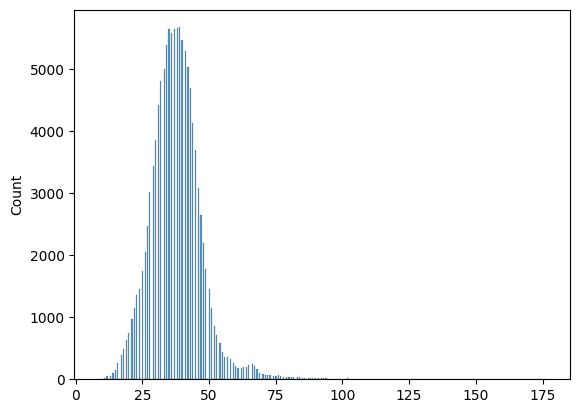

In [8]:
import seaborn as sns
text_lens = pd.Series([len(text.split()) for _, text in data])
sns.histplot(text_lens)

### トークン化

* 単語(token)に分割する(tokenize)
*  torchtext.data.utils.get_tokenizerを使用する

In [9]:
from torchtext.data.utils import get_tokenizer

In [10]:
tokenizer = get_tokenizer("basic_english")
print(tokenizer("I am a student"))

['i', 'am', 'a', 'student']


### イテレータ作成

* 各単語(token)を返すイテレータを作る

In [11]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [12]:
next(yield_tokens(data))

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

### 辞書作成

* torchtext.vacab.build_vocab_from_iteratorを使用する
  * iterator: 単語(token)を返すイテレータ
  * min_freq: 辞書に登録する単語の最小頻度 (デフォルトは1)
  * specials: <unk>などの特別なtokenを予約する
  * vocab[‘word’]のようにしてその単語のindexを取得する
  * .get_itos() で全tokenのリストを取得する
  * .set_default_index(index)で辞書にない単語のデフォルトのindexを指定する

In [13]:
from torchtext.vocab import build_vocab_from_iterator

In [14]:
vocab = build_vocab_from_iterator(iterator=yield_tokens(data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [15]:
vocab["hello"]

12544

In [16]:
# 存在しない単語のindex
vocab["unitabahahahu"]

0

In [17]:
# indexからの逆引き
vocab.get_itos()[12544]

'hello'

### DataLoader作成

In [18]:
train_data[:3]

[(2,
  'SECOND LOOKSnapshots from the latest in college football The boys of Pi Kappa Phi better look out. Mississippi State pulls off the SEC stunner of this Millennium, beating Ron Zook and Florida 38-31.'),
 (1,
  'Summit of French-Speaking Countries Condemns Ivory Coast Leaders at a summit in Burkina Faso of mostly French-speaking nations have condemned authorities in divided Ivory Coast for resuming hostilities in the rebel-held north earlier this month.'),
 (4,
  'Lost faith in Internet Explorer? Try another browser Microsoft has won the browser wars, but a battle is raging for the runner-up spot and one of the contenders has recently been refreshed.')]

In [19]:
import torch
from torch.nn.utils.rnn import pad_sequence

In [20]:
# batch: [(label, text), (label, text),...,]
def collate_batch(batch):
    label_list = []
    text_list = []
    for label, text in batch:
        label_list.append(label - 1)
        text_list.append(torch.tensor([vocab[token] for token in tokenizer(text)])) # ["I am a student"] - >["I", "am", "a", "student"]

    # padding
    label_list = torch.tensor(label_list)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    return label_list, text_list

In [21]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, collate_fn=collate_batch, shuffle=False)

In [22]:
label, text = next(iter(train_loader))
print(label)
print(text)

tensor([2, 2, 3, 1, 3, 3, 1, 0])
tensor([[ 1533,  1145,   492,  1839,     4,  2906,  4113,    12,     9,   132,
           229,    12,     9,   206, 11273,     7,     2,   127,  1486,  1533,
          1768,   492,     8,   185,     2,   381,    63,   786,     6,     2,
            54,    12,     9,   118,   733,    21,   166,     4,   741,  2906,
         17272,    12,   132,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2797,  1444,  6618,   280,    20,  6538,    23,    73,    13,    27,
            14,    15,    51,     1,     9,     1,  1834,    92,  1143,  6618,
           280,    10,    56,    19,    30,   758,  7688,     6,  6678,  1133,
            66,     5,   970,     4,   274,  1017,     3,  1807,    26,     1,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 1129,  

### word embedding matrixの作成

gensimのword2Vecを使用

In [23]:
# google drive のマウント
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Mounted at /content/drive


In [24]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(f'{drive_path}/MyDrive/Deep_Learning/DL_Lecture3/GoogleNews-vectors-negative300.bin', binary=True)

In [25]:
import numpy as np

In [26]:
# unknownには、word2vecの全単語の平均のベクトルを運用する
unk_vector = torch.from_numpy(np.mean(word2vec.vectors, axis=0))
embedding_matrix = torch.zeros((len(vocab), 300))

for i, word in enumerate(vocab.get_itos()):
    if word in word2vec:
        embedding_matrix[i] = torch.from_numpy(word2vec[word])
    else:
        embedding_matrix[i] = unk_vector

<ipython-input-26-890a7794e7c7>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  embedding_matrix[i] = torch.from_numpy(word2vec[word])


### モデル

In [27]:
from torch import nn

In [31]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=None, num_layers=1, rnn_type='LSTM', bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        # embedding layerの追加
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding matrixで重みを初期化
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_size = embedding_dim

        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU", "UGRNN"]')

        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)
        output_seq = output_seq[:, -1, :]
        # output_seq: [batch_size, seq_len, hidden_size*num_directions]
        out = self.fc(output_seq)
        return out


### 学習ループ

In [36]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (labels, sentences) in enumerate(train_loader):
            sentences = sentences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(sentences)
            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

        # 検証データを使用して検証エラーを計算
        model.eval()
        val_loss = 0
        total_samples = 0
        total_correct = 0
        for labels, sentences in val_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            # loss計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # accuracy計算
            _, predicted = torch.max(outputs, dim=-1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = total_correct / total_samples
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [37]:
vocab_size = len(vocab)
num_classes = 4
embedding_dim = 300
hidden_size = 64
output_size = num_classes
learning_rate = 0.001
num_epochs = 3
num_layers = 1

# モデル作成
model = Model(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=embedding_matrix, num_layers=num_layers, rnn_type='LSTM', bidirectional=True)

# 損失関数とOptimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [38]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch 1/3, Average Training Loss: 1.2460
Val Loss: 0.9745, Val Accuracy: 0.4776
Epoch 2/3, Average Training Loss: 0.7141
Val Loss: 0.6346, Val Accuracy: 0.7287
Epoch 3/3, Average Training Loss: 0.3777
Val Loss: 0.3881, Val Accuracy: 0.8824
